In [61]:
import os
import sys

import torch
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

base_dir = os.getcwd()
sys.path.append(base_dir)
sys.path.append(os.path.join(base_dir, 'texture_synthesis_pytorch'))
im_dir = os.path.join(base_dir, 'images')

import utilities as tex_syn_utilities
import model as tex_syn_model
import optimize as tex_syn_opt

TARGET_IMAGE_NAME = 'unity_cube.jpg'

def load_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = os.path.join(base_dir, 'models', 'VGG19_normalized_avg_pool_pytorch')

    target_image_raw = tex_syn_utilities.load_image(os.path.join(im_dir, TARGET_IMAGE_NAME))
    target_image = tex_syn_utilities.preprocess_image(target_image_raw)

    vgg_model = tex_syn_model.Model(os.path.join(base_dir, 'models', 'VGG19_normalized_avg_pool_pytorch'), device, target_image)    
    return vgg_model

def partial_net_at(model, last_layer_index=0):
    partial_net = torch.nn.Sequential()
    for idx, layer in enumerate(list(model.net)[0:last_layer_index+1]):
        partial_net.add_module(str(idx), layer)

    model.gram_loss_hook.clear()
    output = partial_net(model.target_image)
    return output.detach().numpy()

def gram_matrix(activations):
    N = activations.shape[1]
    F = activations.reshape(N, -1)
    M = F.shape[1]
    G = np.dot(F, F.T) / M
    return G

# Generates a template that is of almost double both dimensions
# of the provided feature map and puts the maximum in the center.
#
# Can be used to extract parts of the pattern for further processing
#
def build_manhattan_template(feature_maps, pixel_radius=8):
    feature_map_dimension_x = 2 * feature_maps.shape[1] - 1
    feature_map_dimension_y = 2 * feature_maps.shape[2] - 1

    distance_template = np.ones((feature_map_dimension_x, feature_map_dimension_y))
    distance_template = distance_template * pixel_radius
    
    center_pos_x = feature_map_dimension_x // 2
    center_pos_y = feature_map_dimension_y // 2

    for x in range(feature_map_dimension_x):
        for y in range(feature_map_dimension_y):
            x_dist = np.abs(x - center_pos_x)
            y_dist = np.abs(y - center_pos_y)
            
            if x_dist + y_dist <= pixel_radius:
                distance_template[x, y] = x_dist + y_dist
            
    distance_template = (np.max(distance_template) - distance_template) / np.max(distance_template)
    #plt.imshow(distance_template, cmap='viridis')
    
    #distance_template[np.where(distance_template > 0)] = 1
    
    return distance_template
    
# Takes a feature map (N, Height, Width) and returns a (Height1, Width1, Height2, Width2)
# 4-dimensional distance map where the height2/width2 represent the distance to other pixels
# in the same feature map and height1/width1 correspond to the pixel on which it is centered
# around. The given function can be exchanged to provide different distances, default
# is the manhattan distance.
#
def generate_distance_map(feature_maps, pixel_radius=8, template_func=build_manhattan_template):
    distance_template = template_func(feature_maps, pixel_radius=pixel_radius)
    
    distance_map = np.zeros(feature_maps.shape[1:] + feature_maps.shape[1:])
    center_pos_x = distance_template.shape[0] // 2
    center_pos_y = distance_template.shape[1] // 2
    
    for x in range(feature_maps.shape[1]):
        for y in range(feature_maps.shape[2]):
            template_x = center_pos_x - x
            template_y = center_pos_y - y

            distance_map[x, y, :, :] = distance_template[template_x:template_x+feature_maps.shape[1], template_y:template_y+feature_maps.shape[2]]
            distance_map[x, y, :, :] /= np.sum(distance_map[x, y, :, :])
            
    return distance_map

In [73]:
model = load_model()
#out_batch = partial_net_at(model, 4)
out_batch = partial_net_at(model, 9)
#out_batch = partial_net_at(model, 18)
#out_batch = partial_net_at(model, 27)
out = out_batch[0, :, :, :]
gr = gram_matrix(out_batch)

distance_map = generate_distance_map(out, pixel_radius=4)

num_output_repetition = 4
out_large = np.broadcast_to(out, (num_output_repetition,) + out.shape)

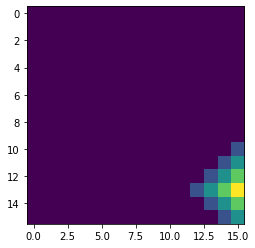

In [69]:
plt.imshow(gr, cmap='viridis')
plt.imshow(distance_map[13, 15, :, :], cmap='viridis')

In [74]:
"""
new = np.empty((out.shape[0],) + distance_map.shape[:2])
for i in range(out.shape[0]):
    new[i, :, :] = np.sum(out[i, :, :] * distance_map, axis=(2,3))
"""



def old_calc(out, distance_map):
    new = np.empty((out.shape[0],) + distance_map.shape[:2])
    for i in range(out.shape[0]):
        new[i, :, :] = np.sum(out[i, :, :] * distance_map, axis=(2,3))
    return new

@jit(nopython=True)
def new_calc(out, distance_map):
    new = np.empty((out.shape[0],) + distance_map.shape[:2])
    for i in np.arange(out.shape[0]):
        tmp = out[i, :, :] * distance_map
        new[i, :, :] = np.sum(tmp, axis=(2,3))
    return new

a = np.sum(out[0, :, :] * distance_map, axis=(2,3))



In [6]:
%%time
n1 = old_calc(out, distance_map)

CPU times: user 4.23 s, sys: 844 ms, total: 5.07 s
Wall time: 5.07 s


In [38]:
%%time
n2 = new_calc(out, distance_map)
# Currently not supported in Numba to have axis=(2,3) "tuple"
# see https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html#other-methods

LoweringError: Failed in nopython mode pipeline (step: native lowering)
No definition for lowering <function sum at 0x7f30bc0c1320>(array(float64, 4d, C), Tuple(Literal[int](2), Literal[int](3))) -> array(float64, 3d, C)

File "../../../../tmp/ipykernel_29755/657264657.py", line 20:
<source missing, REPL/exec in use?>

During: lowering "$92call_function_kw.21 = call $84load_attr.17(tmp, func=$84load_attr.17, args=[Var(tmp, 657264657.py:19)], kws=[('axis', Var($const88.19, 657264657.py:20))], vararg=None, target=None)" at /tmp/ipykernel_29755/657264657.py (20)

In [75]:
new = old_calc(out, distance_map)
new_gram = gram_matrix(new)
np.fill_diagonal(new_gram, 0)

Text(0.5, 1.0, 'Gram: Blurred FM-Products')

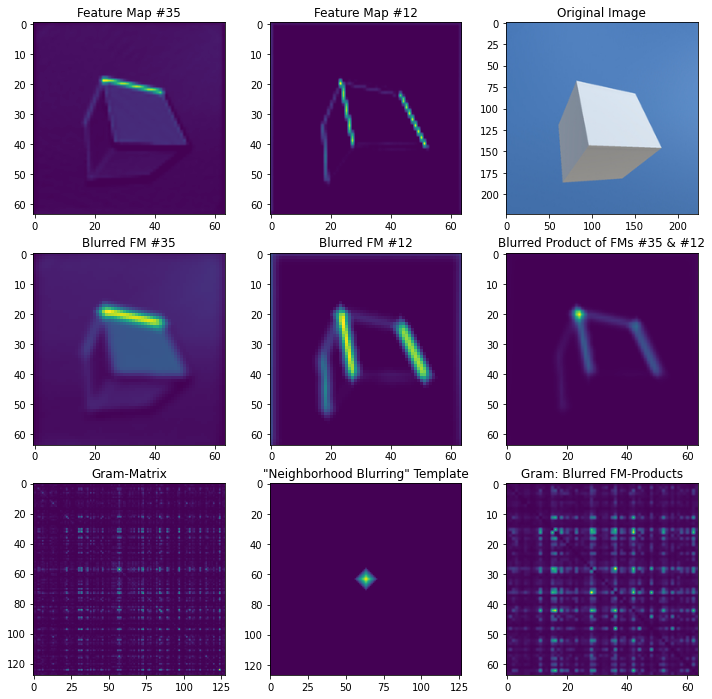

In [76]:
#INDEX_A = np.random.randint(0, out.shape[0])
#INDEX_B = np.random.randint(0, out.shape[0])
INDEX_A = 35
INDEX_B = 12

fig, axs = plt.subplots(3, 3, figsize=(12,12))

# Feature Map INPUT
axs[0,0].imshow(out[INDEX_A, :, :], cmap='viridis')
axs[0,0].set_title('Feature Map #' + str(INDEX_A))
axs[0,1].imshow(out[INDEX_B, :, :], cmap='viridis')
axs[0,1].set_title('Feature Map #' + str(INDEX_B))
axs[0,2].imshow(tex_syn_utilities.load_image(os.path.join(im_dir, TARGET_IMAGE_NAME)))
axs[0,2].set_title('Original Image')

# Feature Map "Distance-Scaled"
axs[1,0].imshow(new[INDEX_A, :, :], cmap='viridis')
axs[1,0].set_title('Blurred FM #' + str(INDEX_A))
axs[1,1].imshow(new[INDEX_B, :, :], cmap='viridis')
axs[1,1].set_title('Blurred FM #' + str(INDEX_B))
# Feature Maps multiplied with distance scaling
axs[1,2].imshow(new[INDEX_A, :, :] * new[INDEX_B, :, :], cmap='viridis')
axs[1,2].set_title('Blurred Product of FMs #' + str(INDEX_A) + ' & #' + str(INDEX_B))

# Original Gram Matrix
axs[2,0].imshow(gr, cmap='viridis')
axs[2,0].set_title('Gram-Matrix')
axs[2,1].imshow(build_manhattan_template(out), cmap='viridis')
axs[2,1].set_title('"Neighborhood Blurring" Template')
# Gram Matrix of distance scaled product
axs[2,2].imshow(new_gram, cmap='viridis')
axs[2,2].set_title('Gram: Blurred FM-Products')

Text(0.5, 1.0, 'Gram: Blurred FM-Products')

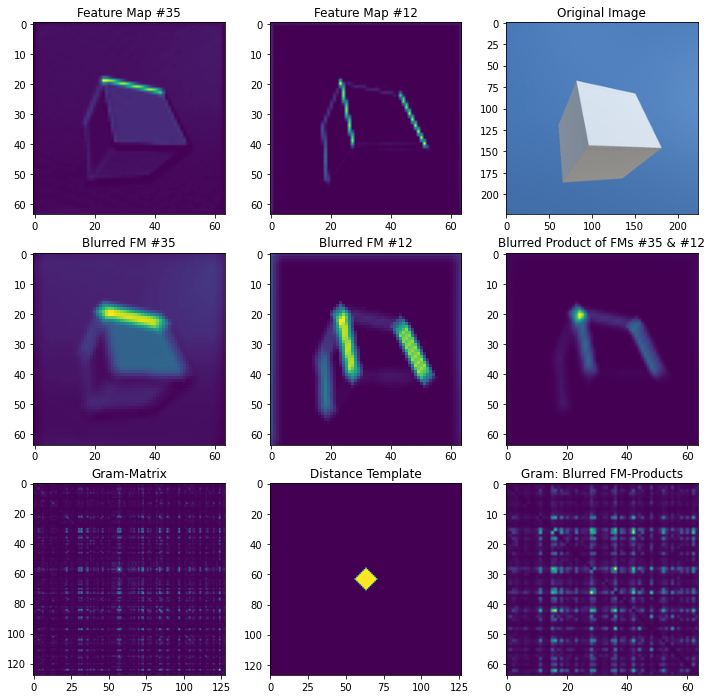

In [59]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))

# Feature Map INPUT
axs[0,0].imshow(out[INDEX_A, :, :], cmap='viridis')
axs[0,0].set_title('Feature Map #' + str(INDEX_A))
axs[0,1].imshow(out[INDEX_B, :, :], cmap='viridis')
axs[0,1].set_title('Feature Map #' + str(INDEX_B))
axs[0,2].imshow(tex_syn_utilities.load_image(os.path.join(im_dir, TARGET_IMAGE_NAME)))
axs[0,2].set_title('Original Image')

# Feature Map "Distance-Scaled"
axs[1,0].imshow(new[INDEX_A, :, :], cmap='viridis')
axs[1,0].set_title('Blurred FM #' + str(INDEX_A))
axs[1,1].imshow(new[INDEX_B, :, :], cmap='viridis')
axs[1,1].set_title('Blurred FM #' + str(INDEX_B))
# Feature Maps multiplied with distance scaling
axs[1,2].imshow(new[INDEX_A, :, :] * new[INDEX_B, :, :], cmap='viridis')
axs[1,2].set_title('Blurred Product of FMs #' + str(INDEX_A) + ' & #' + str(INDEX_B))

# Original Gram Matrix
axs[2,0].imshow(gr, cmap='viridis')
axs[2,0].set_title('Gram-Matrix')
axs[2,1].imshow(build_manhattan_template(out), cmap='viridis')
axs[2,1].set_title('Distance Template')
# Gram Matrix of distance scaled product
axs[2,2].imshow(new_gram, cmap='viridis')
axs[2,2].set_title('Gram: Blurred FM-Products')